In [1]:
suppressPackageStartupMessages({
library(Seurat)
library(cowplot)
library(Matrix)
library(dplyr)
library(future)
library(ggplot2)
library(reshape2)
library(tictoc)
library(SingleR)
})

# Load and select myeloid subpopulations

In [10]:
tic()
load(file = "Colon_0.6_0730.RDS")
toc()


20.013 sec elapsed


In [14]:
#immgen <- ImmGenData()
load(file="immgen.rda")

SingleR_Annotation <- function(seu, reference="HPCA", use_local=T){
    if (use_local==F){
        if       (reference=="HPCA"){
            ref <- HumanPrimaryCellAtlasData()   
        }else if (reference=="BED"){
            ref <- BlueprintEncodeData()
        }else if (reference=="DbImmExp"){
            ref <- DatabaseImmuneCellExpressionData()
        }else if (reference=="Hemato"){
            ref <- NovershternHematopoieticData()
        }else if (reference=="Monaco"){
            ref <- MonacoImmuneData()
        }else if (reference=="ImmGen"){
            ref <- ImmGenData()
        }else if (reference=="MouseRNA"){
            ref <- MouseRNAseqData()
        }else{
            ref <- HumanPrimaryCellAtlasData()   
        }
    }else{
        if       (reference=="HPCA"){
            ref <- hpca
        }else if (reference=="BED"){
            ref <- blueprint
        }else if (reference=="DbImmExp"){
            ref <- dbimmexp
        }else if (reference=="Hemato"){
            ref <- hemato
        }else if (reference=="Monaco"){
            ref <- monaco
        }else if (reference=="ImmGen"){
            ref <- immgen
        }else if (reference=="MouseRNA"){
            ref <- mmrna
        }else{
            ref <- hpca
        }
    }
    
        
    mat       <- GetAssayData(seu, slot="data")
    pred.fine <- SingleR(test = mat, ref = ref, labels = ref$label.fine)
    pred.main <- SingleR(test = mat, ref = ref, labels = ref$label.main)
       
    seu[[paste0(reference,"_main")]]<-pred.main$pruned.labels
    seu[[paste0(reference,"_fine")]]<-pred.fine$pruned.labels
    return(seu) 
}

In [16]:
myeloid<-subset(immune.combined, subset=`celltype0627`=='4.Myeloid phagocytes'|`celltype0627`=='5.Ly2Z+ Myeloid'|`celltype0627`=='15.CX3CR1+ Mac')

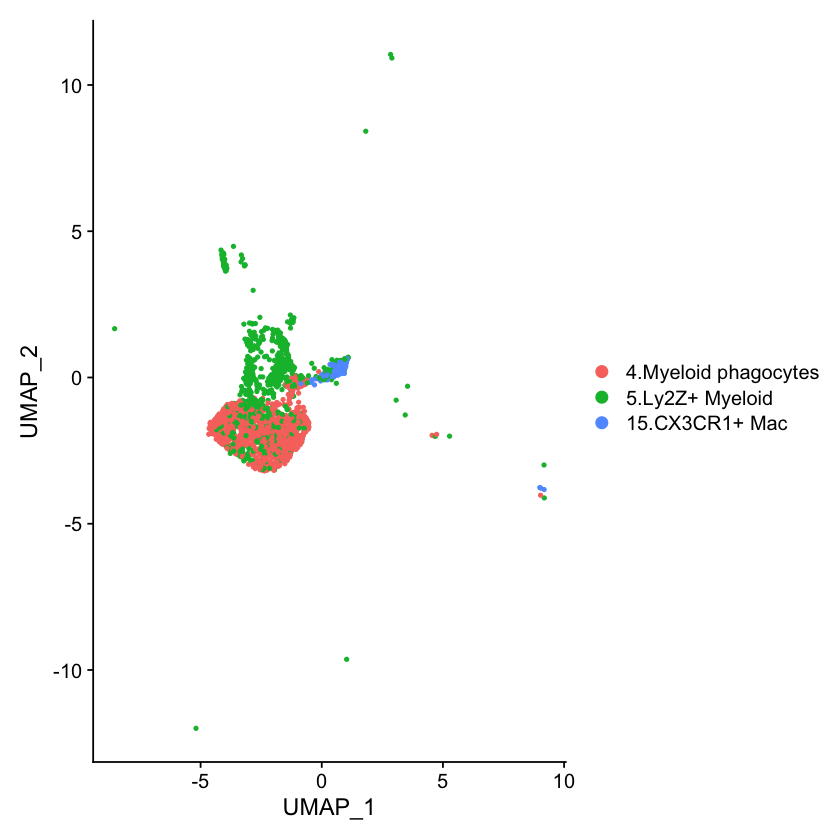

In [17]:
DimPlot(myeloid, group.by="celltype0627")

# Algorithmic annotation

In [18]:
tic()
DefaultAssay(myeloid)<-"RNA"
myeloid<-SingleR_Annotation(seu=myeloid, reference="ImmGen", use_local=T)
toc()

200.722 sec elapsed


# Reclustering of myeloid populations

In [ ]:
DefaultAssay(myeloid)<-"integrated"
myeloid <-SCTransform(myeloid, verbose = F)
myeloid <-RunPCA(myeloid,  npcs=50, verbose = FALSE)
myeloid <-RunUMAP(myeloid, dims=1:30, verbose=FALSE, min.dist=0.1, n.neighbors = 20L)


In [23]:
myeloid <- FindNeighbors(myeloid, dims = 1:20)
myeloid <- FindClusters(myeloid, resolution = c(0.1,0.2,0.3,0.4,0.5))

Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 1951
Number of edges: 69911

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9154
Number of communities: 3
Elapsed time: 0 seconds
Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 1951
Number of edges: 69911

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8672
Number of communities: 5
Elapsed time: 0 seconds
Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 1951
Number of edges: 69911

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8276
Number of communities: 6
Elapsed time: 0 seconds
Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 1951
Number of edges: 69911

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8036
Number of communities: 7
Elapsed time: 0 seconds
Modularity Optimizer ver

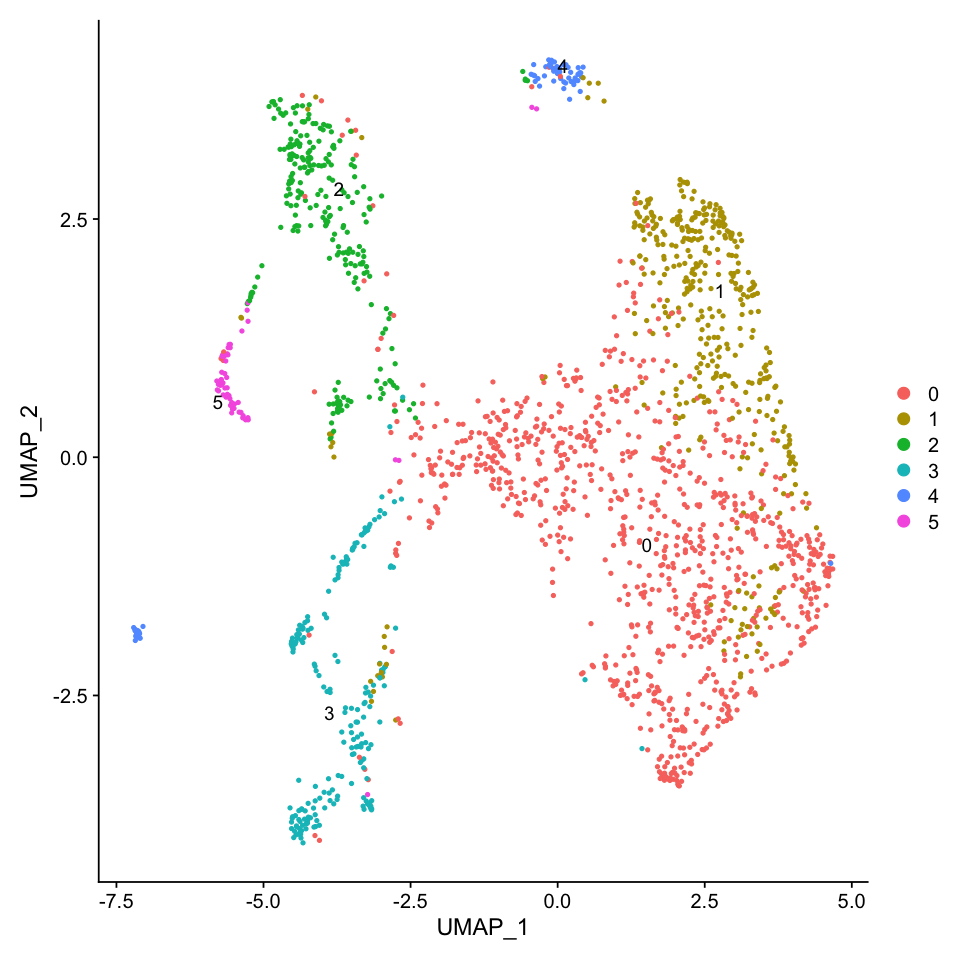

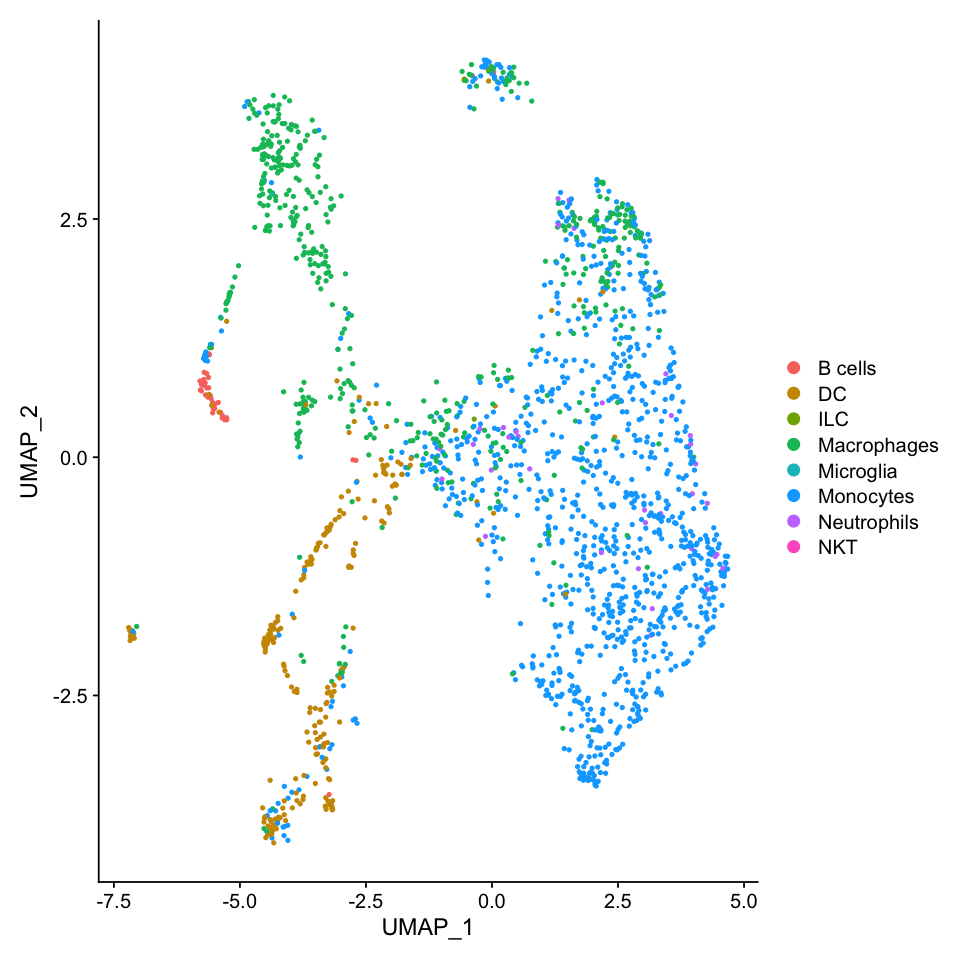

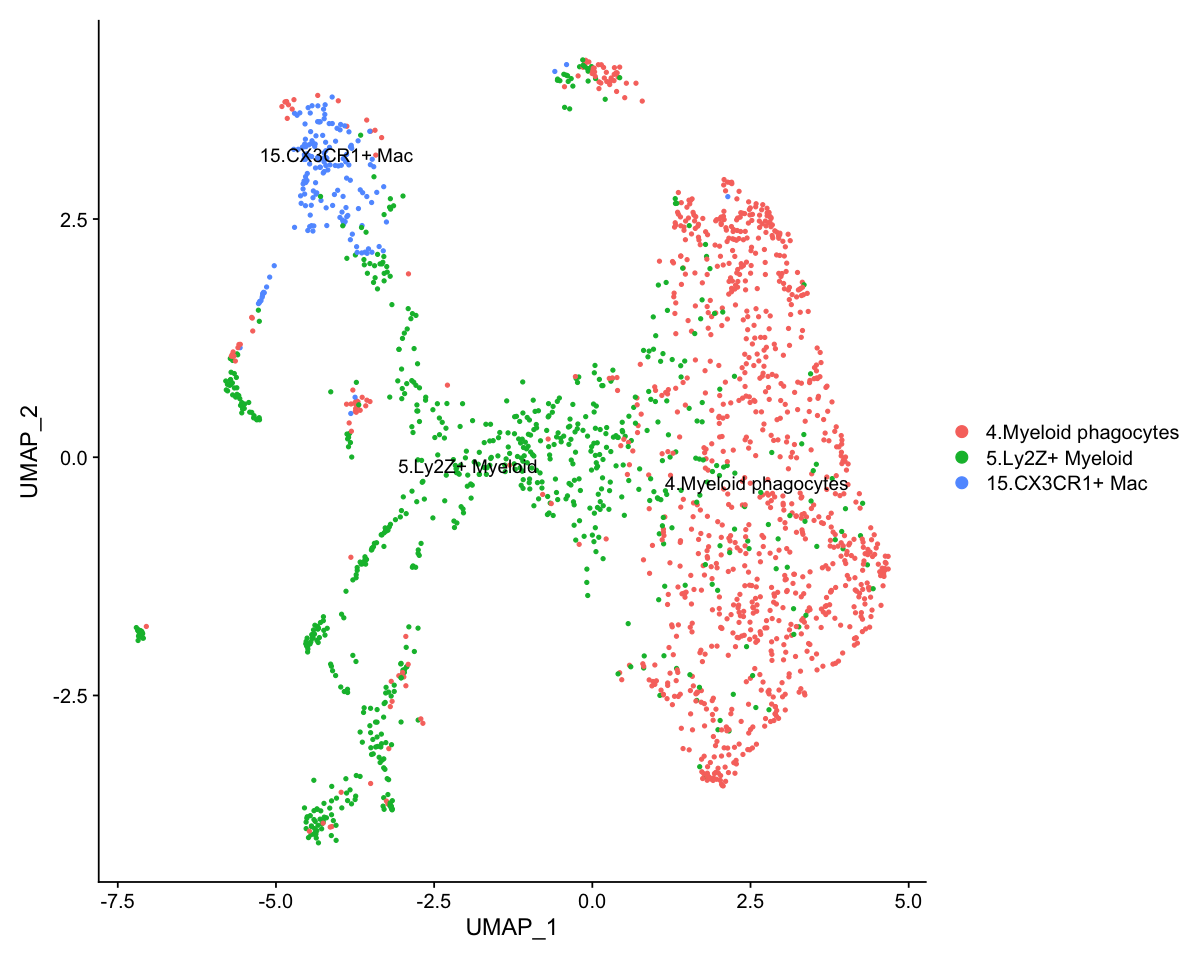

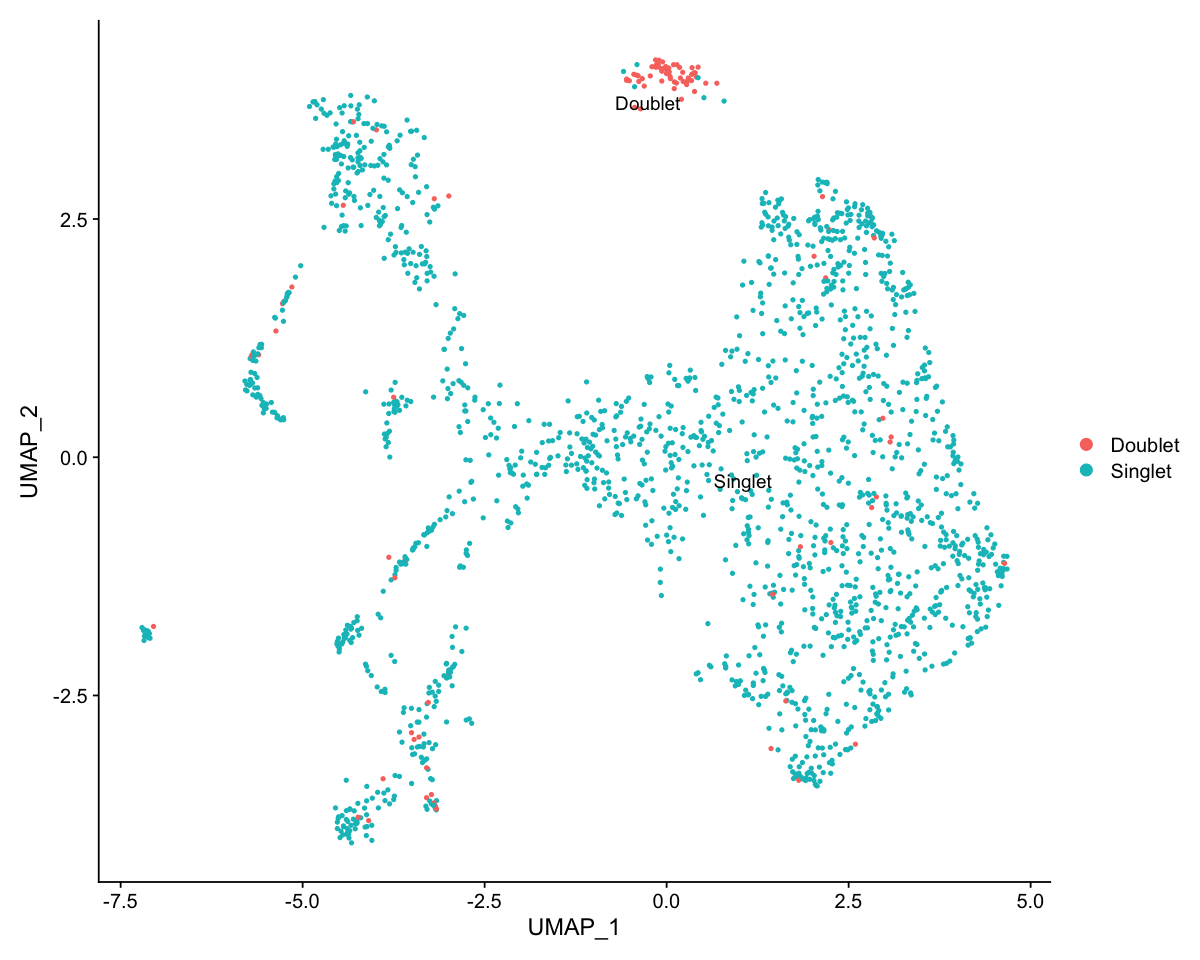

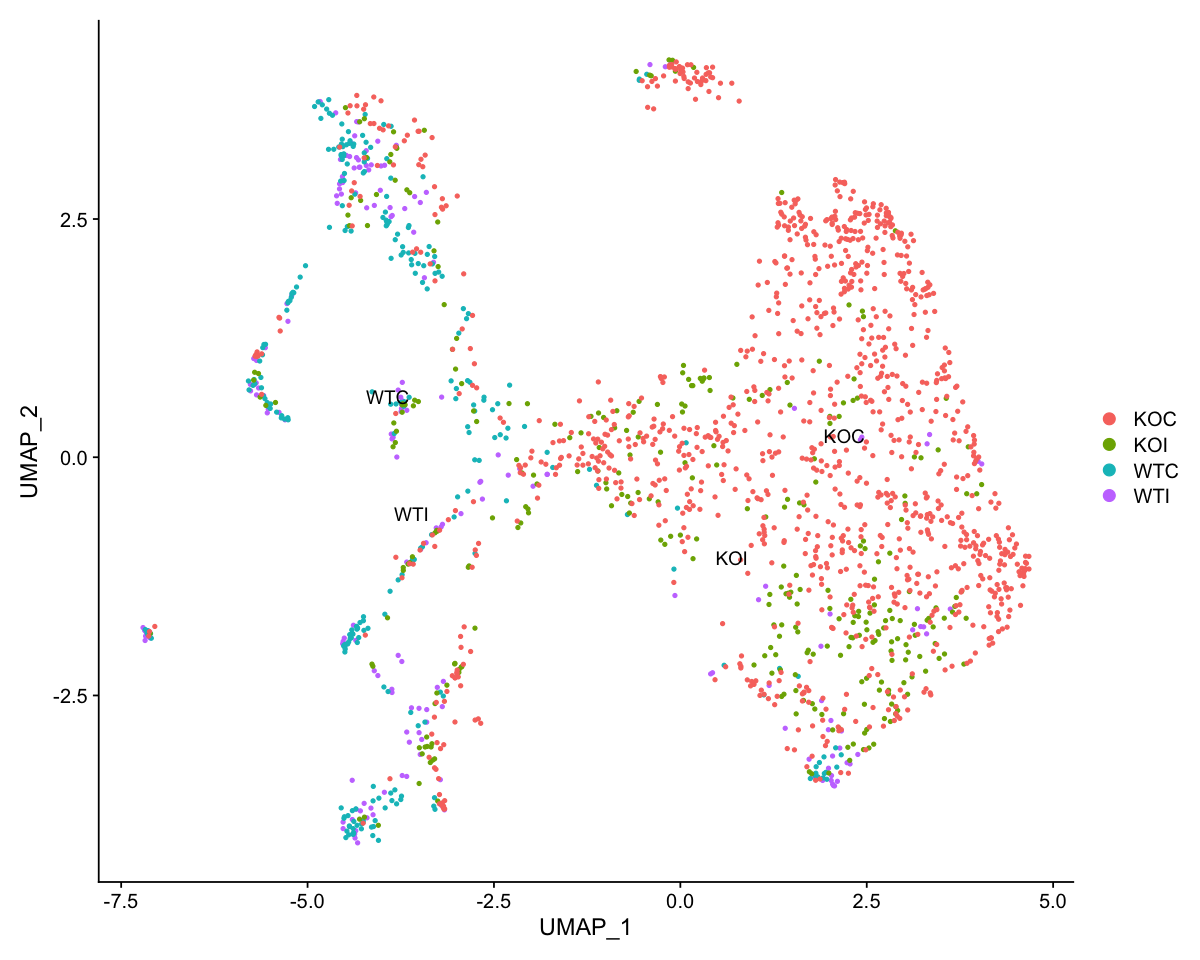

In [25]:
#myeloid<-RunUMAP(myeloid, dims=1:30, verbose=FALSE, min.dist=0.2, n.neighbors = 20L)
options(repr.plot.width=8, repr.plot.height=8)
DimPlot(myeloid, group.by="SCT_snn_res.0.3", label=T, repel=T)
DimPlot(myeloid, group.by="ImmGen_main")

options(repr.plot.width=10, repr.plot.height=8)
DimPlot(myeloid, group.by="celltype0627",label=T, repel=T)
DimPlot(myeloid, group.by="DF",label=T, repel=T)
DimPlot(myeloid, group.by="stim",label=T, repel=T)
#options(repr.plot.width=20, repr.plot.height=8)
#DimPlot(myeloid, group.by="ImmGen_fine")

# Visualization of important markers

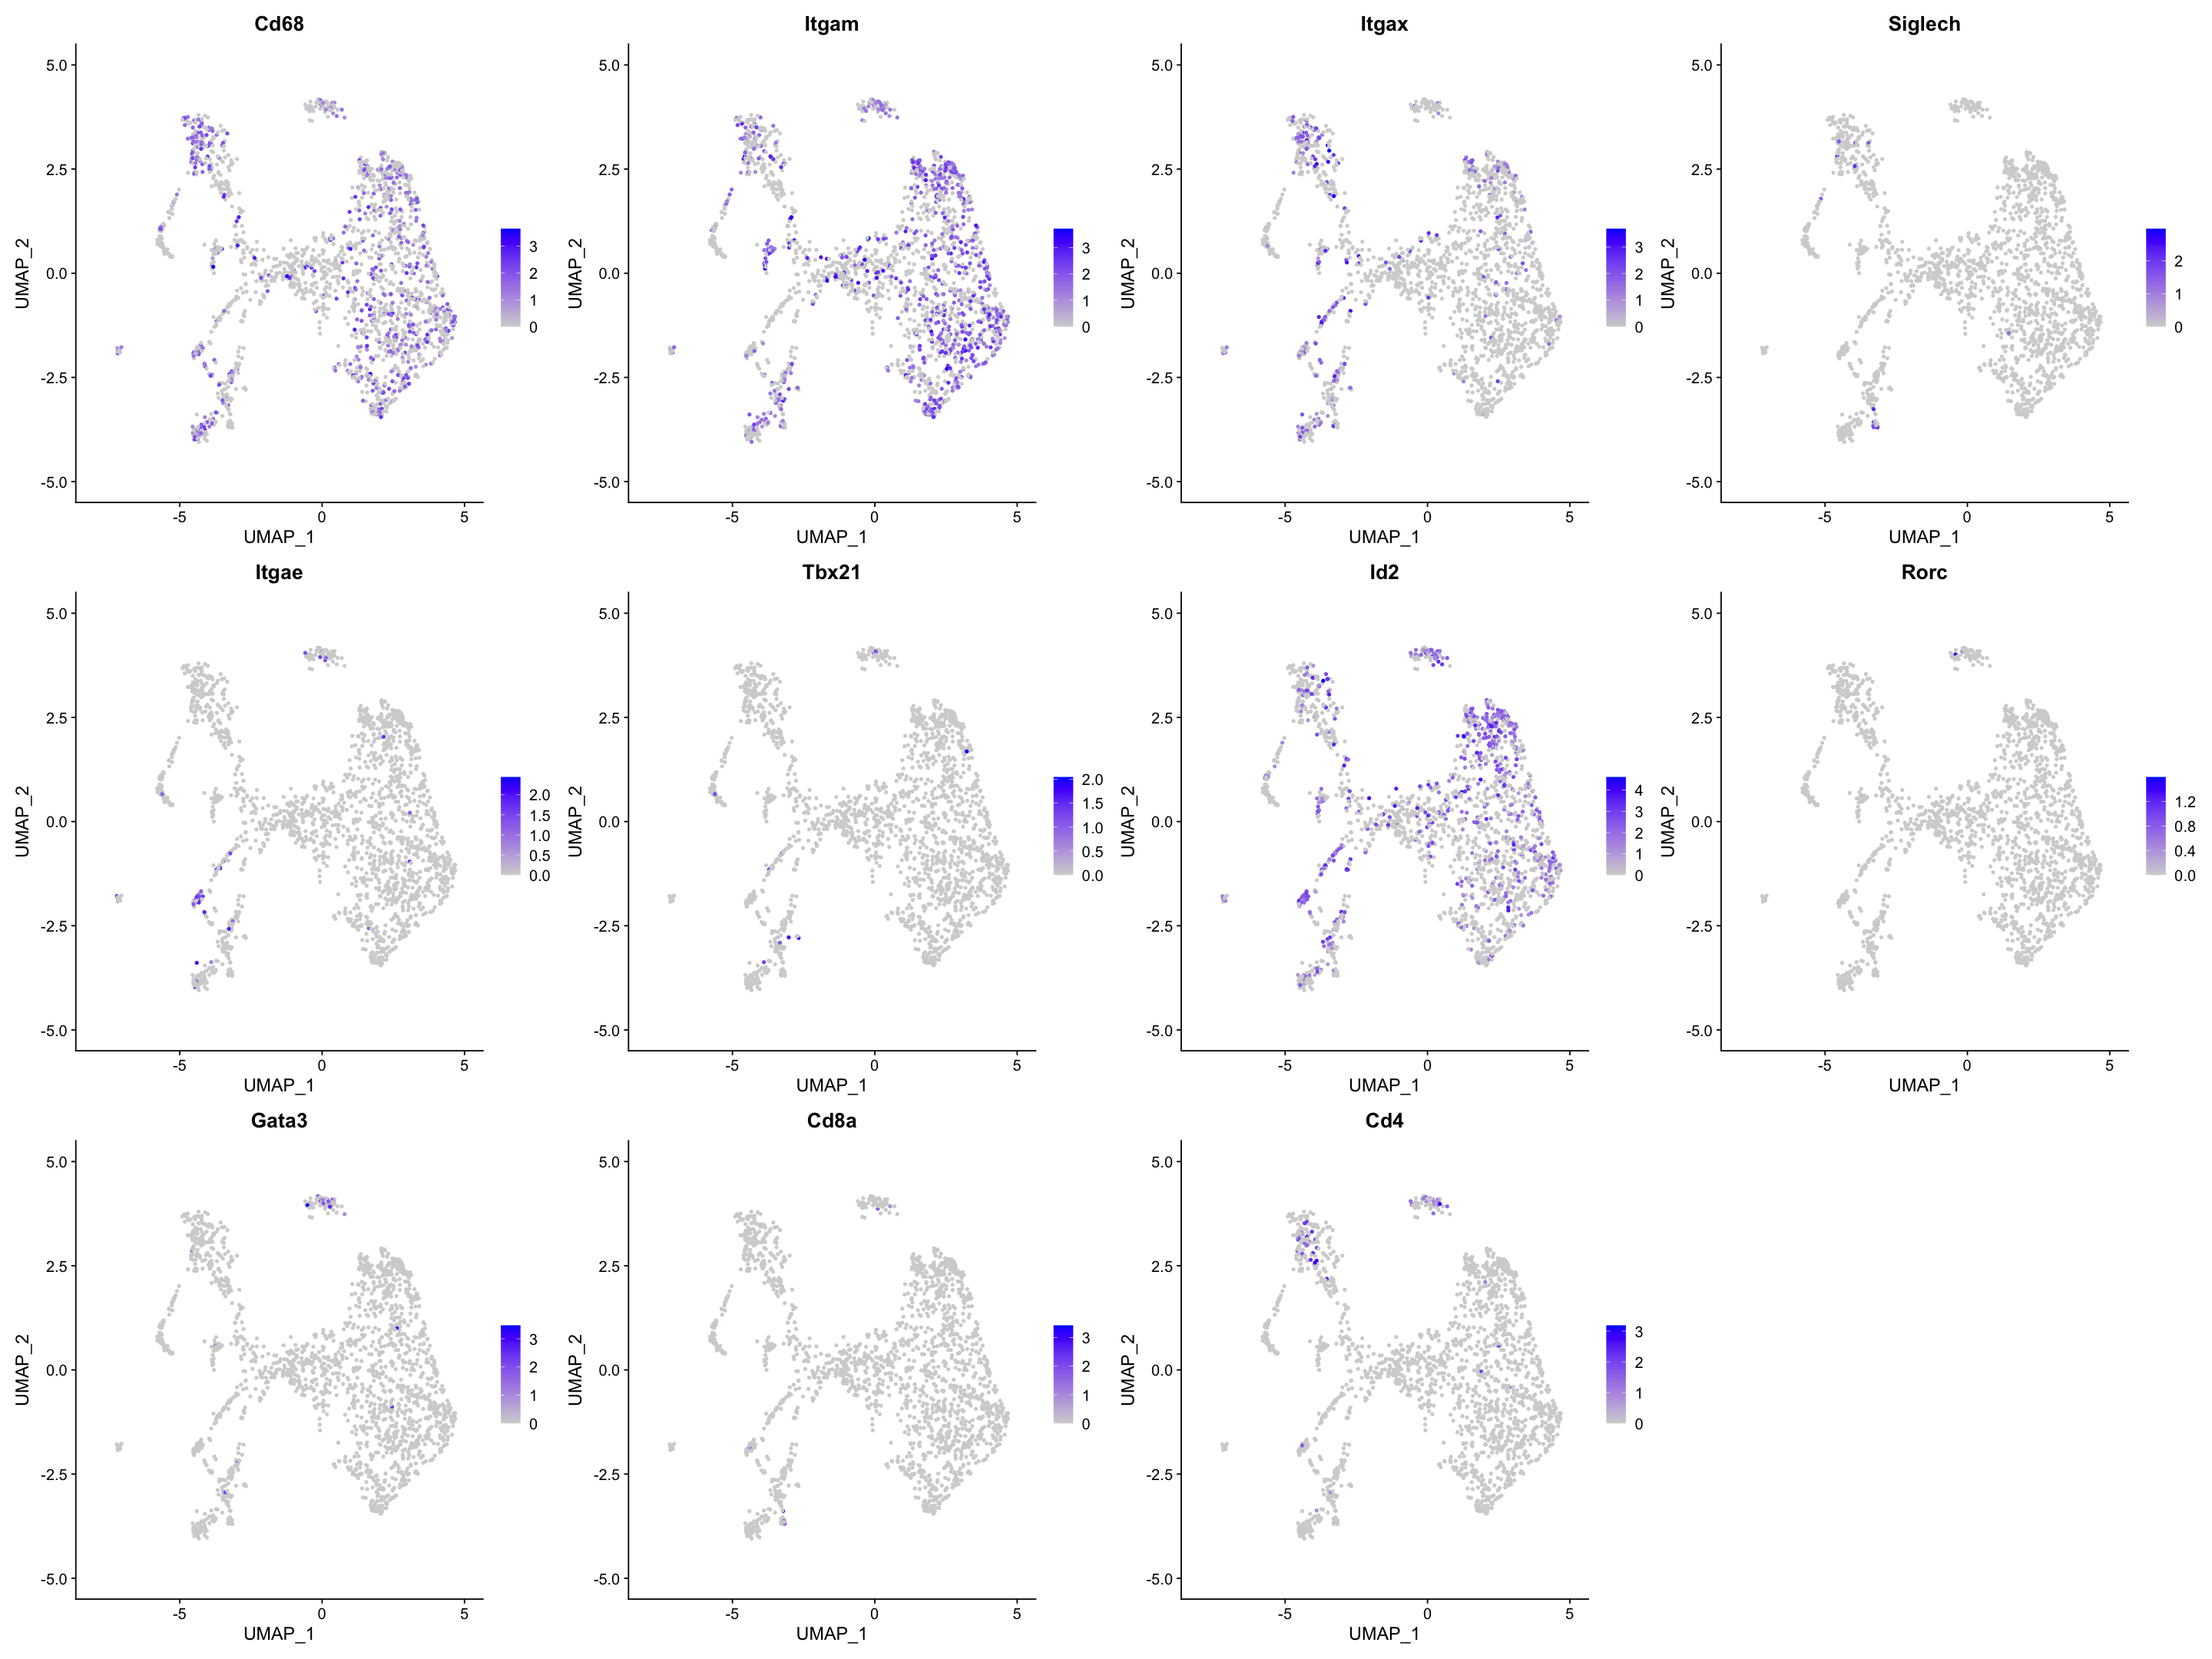

In [26]:
options(repr.plot.width=6*4, repr.plot.height=6*3)
DefaultAssay(myeloid)<-"RNA"
FeaturePlot(myeloid, reduction="umap", ncol=4,features=c("Cd68","Itgam","Itgax","Siglech","Itgae","Tbx21","Id2","Rorc","Gata3","Cd8a","Cd4"))

# Rename clusters

In [27]:
Idents(myeloid)<-"SCT_snn_res.0.3"
myeloid<-RenameIdents(myeloid, 
                      '0'='Monocytes', 
                      '1'='Mac & cDC2', 
                      '2'='CX3CR1+Mac',
                      '3'='cDC1',
                      '4'='doublets',
                      '5'='B')

In [32]:
myeloid[["celltype0730"]]<-Idents(myeloid)

In [35]:
# remove doublets
myeloid.clean = subset(myeloid, subset=celltype0730!="doublets" & DF!="Doublet")

In [19]:
options(repr.plot.width=10, repr.plot.height=8)
pdf(width=10, height=10, file="myeloid.clean.celltype0627.pdf")
DimPlot(myeloid.clean, group.by="celltype0627",label=T, repel=T)+theme(legend.position = c(0.8,0.9))
dev.off()

pdf 
  2

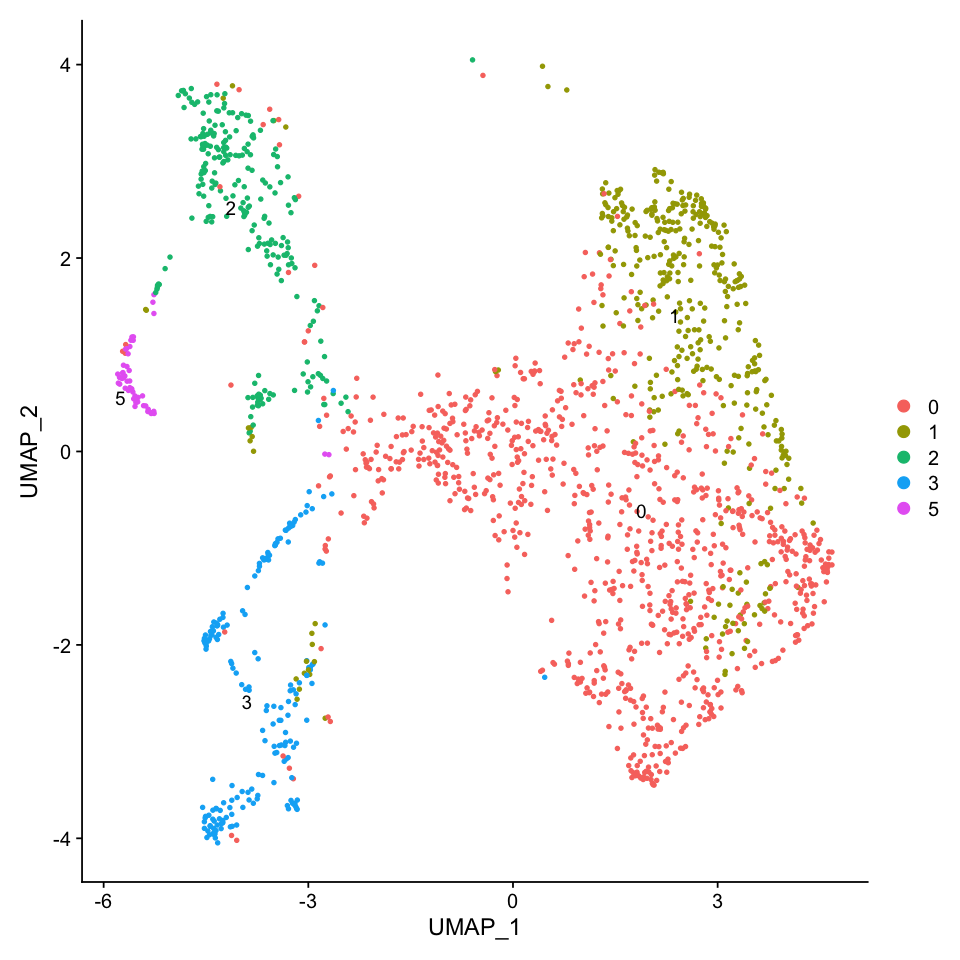

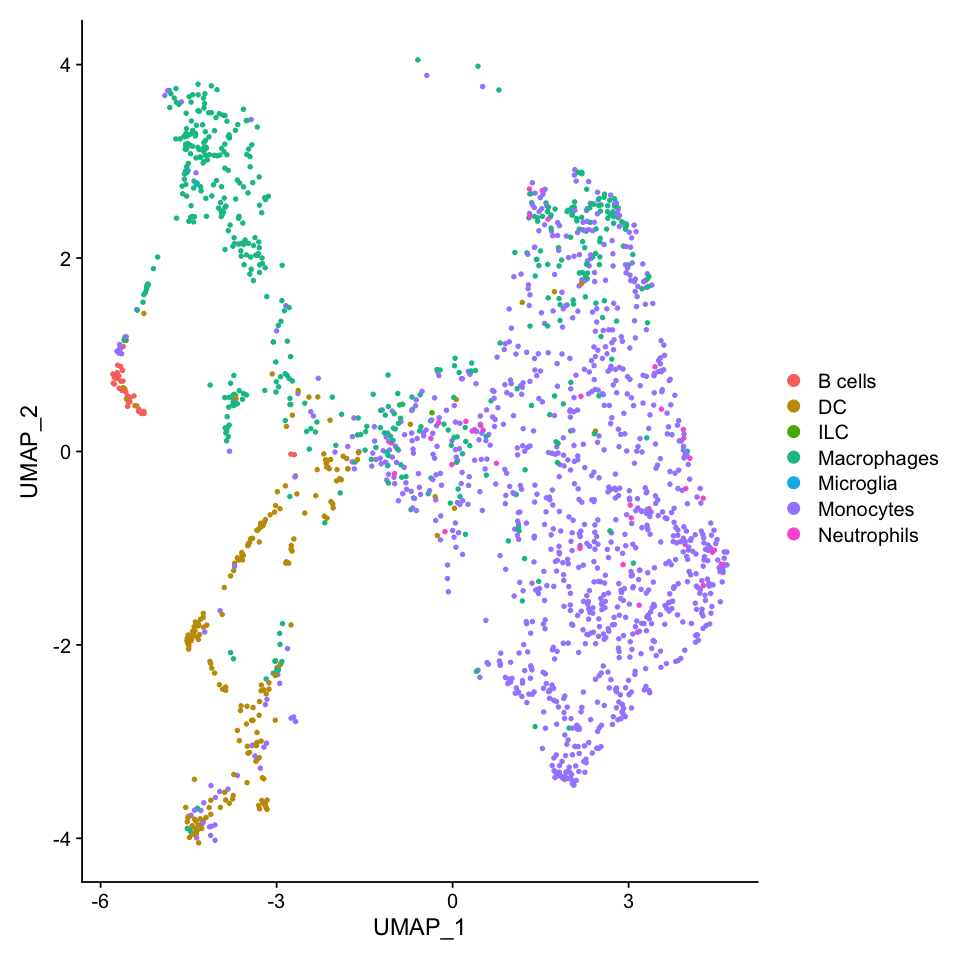

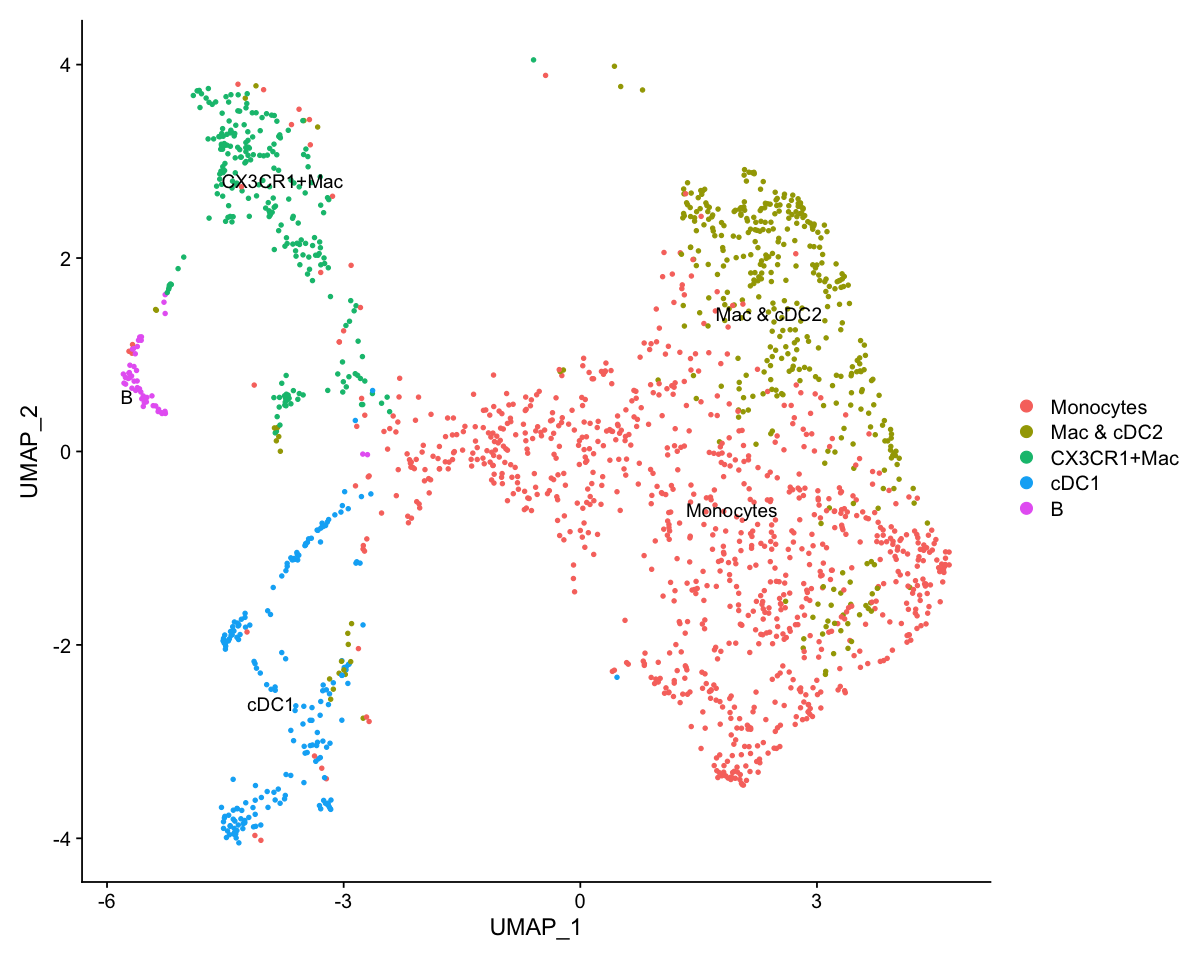

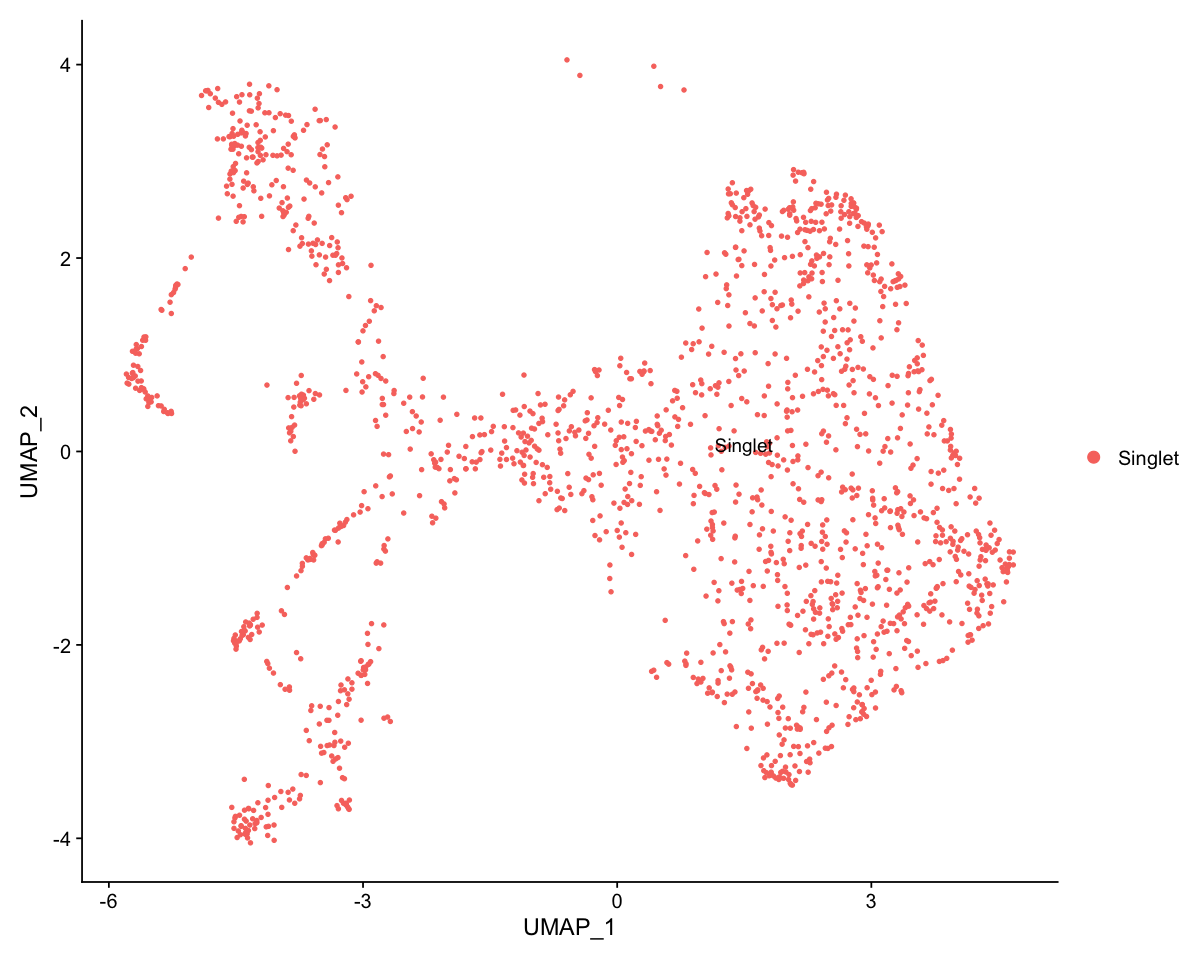

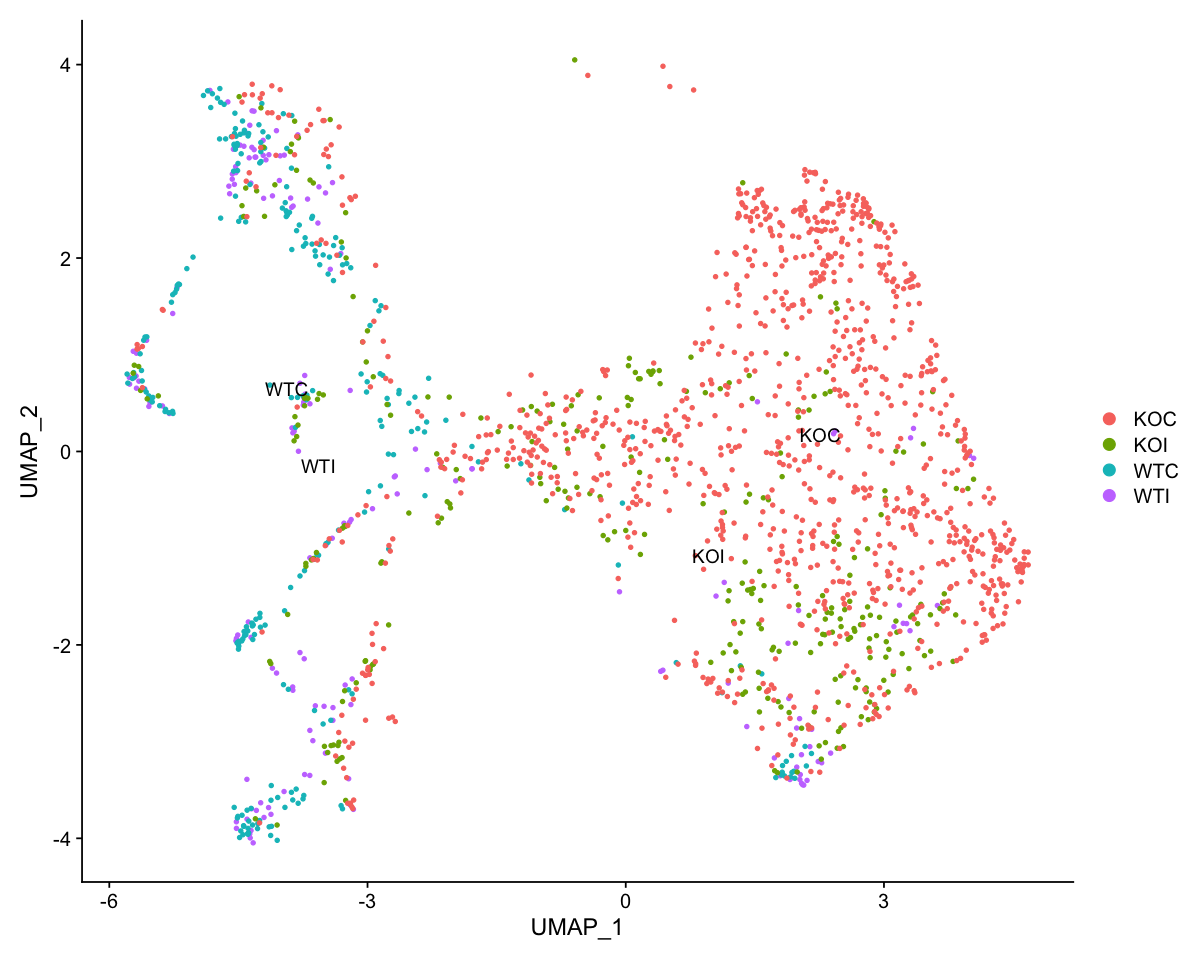

In [38]:
options(repr.plot.width=8, repr.plot.height=8)
DimPlot(myeloid.clean, group.by="SCT_snn_res.0.3", label=T, repel=T)
DimPlot(myeloid.clean, group.by="ImmGen_main")

options(repr.plot.width=10, repr.plot.height=8)
DimPlot(myeloid.clean, group.by="celltype0730",label=T, repel=T)
DimPlot(myeloid.clean, group.by="DF",label=T, repel=T)
DimPlot(myeloid.clean, group.by="stim",label=T, repel=T)

In [39]:
DefaultAssay(myeloid.clean)<-"RNA"
Idents(myeloid.clean)<-"celltype0730"
myeloid.markers<-FindAllMarkers(myeloid.clean, only.pos=T, return.thresh = 0.01)

Calculating cluster Monocytes

Calculating cluster Mac & cDC2

Calculating cluster CX3CR1+Mac

Calculating cluster cDC1

Calculating cluster B



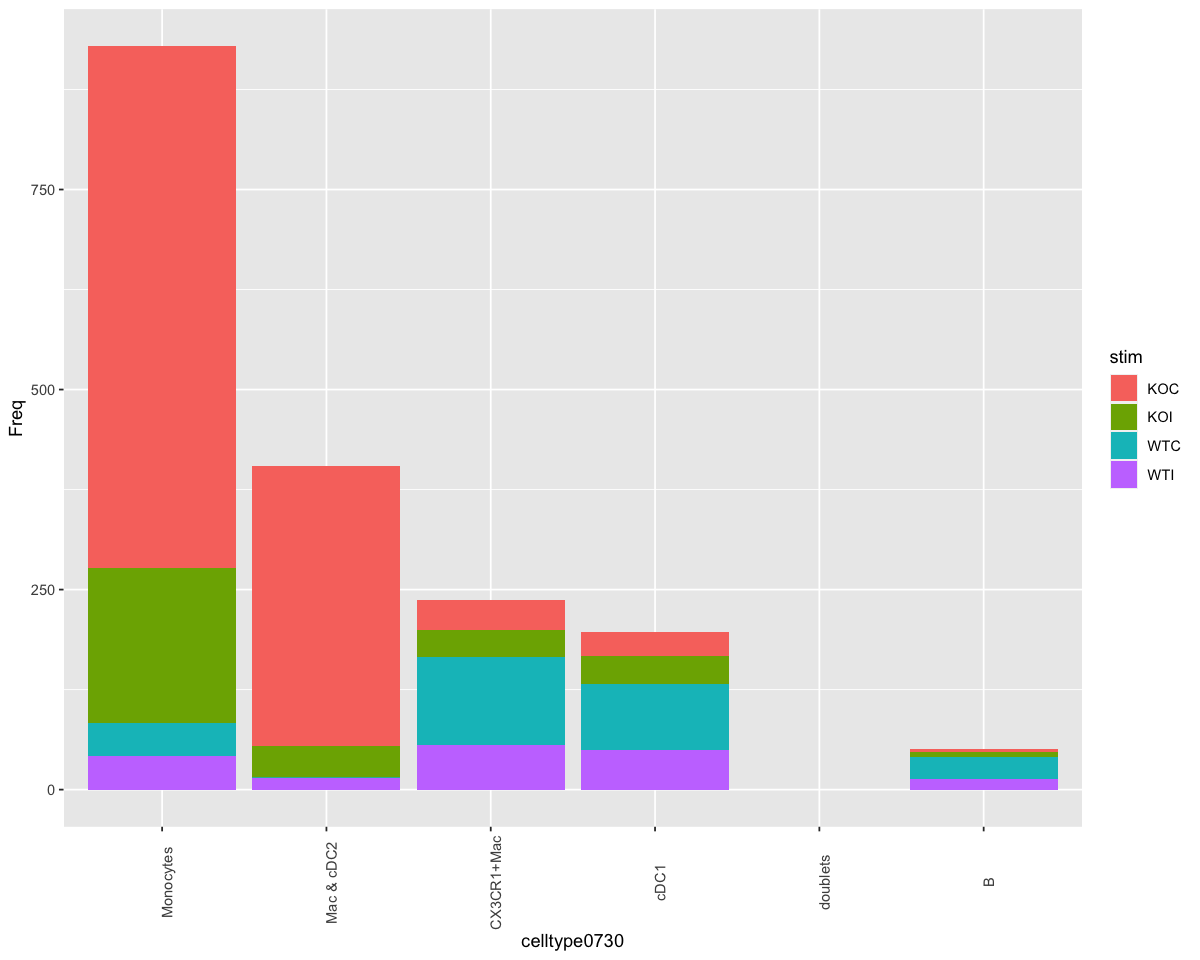

In [45]:
celltypedata=myeloid.clean[[]][,c("stim","celltype0730")]
celltypedata=as.data.frame(table(celltypedata))


ggplot(celltypedata, aes(fill=stim, y=Freq, x=celltype0730)) + 
    geom_bar(position="stack", stat="identity")+ theme(axis.text.x = element_text(angle = 90)) 


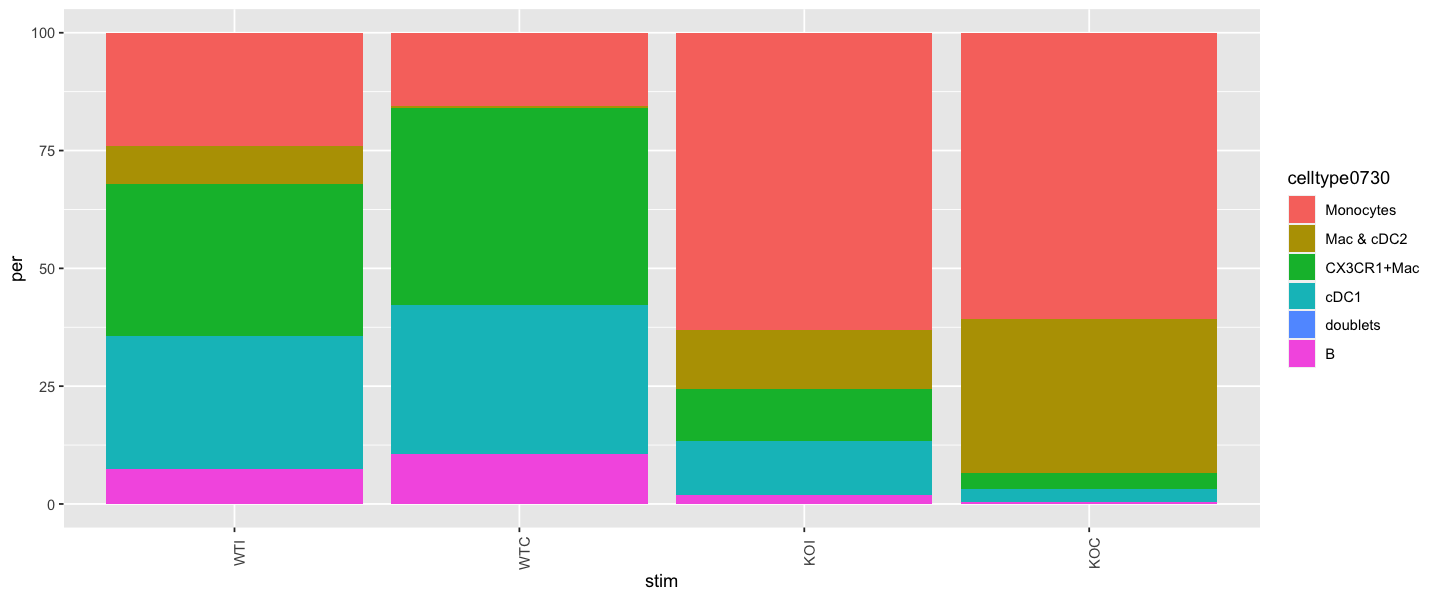

In [64]:
celltypedata %>%
    group_by(stim) %>%
    mutate(countT= sum(Freq)) %>%
    group_by(celltype0730, add=TRUE) %>%
    mutate(per=round(100*Freq/countT,2)) ->celltypeper

#celltypeper
options(repr.plot.width=12, repr.plot.height=5)
ggplot(celltypeper, aes(fill=celltype0730, y=per, x=stim)) + 
    geom_bar(position="stack", stat="identity")+ theme(axis.text.x = element_text(angle = 90)) +
 scale_x_discrete(limits = c("WTI","WTC","KOI","KOC"))

# Identify DEG (differentially expressed genes)

In [73]:
myeloid.clean@meta.data[,"celltype0730_stim"] = paste(myeloid.clean@meta.data[,"celltype0730"],myeloid.clean@meta.data[,"stim"],  sep="_")

In [ ]:
Idents(myeloid.clean) <- "celltype0730_stim"
library(tictoc)
tic()
deg.Monocytes_KOI <- FindMarkers(myeloid.clean, ident.1 = "Monocytes_KOI", ident.2 = "Monocytes_KOC", verbose = FALSE, only.pos=T)
deg.Monocytes_KOC <- FindMarkers(myeloid.clean, ident.1 = "Monocytes_KOC", ident.2 = "Monocytes_KOI", verbose = FALSE, only.pos=T)
toc()

In [78]:
Idents(myeloid.clean) <- "celltype0730_stim"
levels(myeloid.clean)

[1] "CX3CR1+Mac_WTI" "cDC1_WTI"       "Monocytes_WTI"  "Mac & cDC2_WTI"
 [5] "B_WTI"          "Monocytes_WTC"  "CX3CR1+Mac_WTC" "B_WTC"         
 [9] "cDC1_WTC"       "Mac & cDC2_WTC" "Monocytes_KOI"  "CX3CR1+Mac_KOI"
[13] "Mac & cDC2_KOI" "cDC1_KOI"       "B_KOI"          "Monocytes_KOC" 
[17] "CX3CR1+Mac_KOC" "Mac & cDC2_KOC" "cDC1_KOC"       "B_KOC"

In [79]:
############  some snippet necessary for DEG analysis ############ 
### define a function to clean the DEG results
filter.deg<- function(markers, p_val_adj.cutoff=0.05, avg_logFC.cutoff=0, pct.1.cutoff=0, pct.2.cutoff=1){
  markers<-markers[markers$p_val_adj<p_val_adj.cutoff, ]
  markers<-markers[markers$avg_logFC>avg_logFC.cutoff, ]
  markers<-markers[markers$pct.1 > pct.1.cutoff, ]
  markers<-markers[markers$pct.2 < pct.2.cutoff, ]
  markers$gene  <-  rownames(markers)
  markers$log2FC<-  log2(exp(markers$avg_logFC))
  markers$FC    <-  exp(markers$avg_logFC)
  return(markers[order(-markers$avg_logFC), ])
}
### load gene list necessary for gene annotation from github
load(url("https://github.com/chansigit/SSAT/raw/master/mm.cellsurfacemarker.rda"))
load(url("https://github.com/chansigit/SSAT/raw/master/mm.secretory.rda"))
load(url("https://github.com/chansigit/SSAT/raw/master/mm.tf.rda"))

### load gene annotation function from github
source("https://raw.github.com/chansigit/SSAT/master/annotate.genelist.R")



In [90]:
setwd("/Users/yzhou14/Data_local/20200627_scRNAseq_analysis/DEG_analysis_results(myeloid)/")

In [94]:
# one-dragon-run 
# batch processing for high throughput DEG identifications

seu <- myeloid.clean
DefaultAssay(seu)<-"RNA" # always remember to use RNA slot for DEG analysis
library("EnhancedVolcano")
Idents(seu)<-"celltype0730_stim"

#set the working directory to save results
setwd("/Users/yzhou14/Data_local/20200627_scRNAseq_analysis/DEG_analysis_results(myeloid)/")
for (celltype in c('Monocytes','CX3CR1+Mac','cDC1','B')){ 
    for (cmp in c("KOI.vs.KOC", "WTI.vs.WTC", "WTI.vs.KOI", "WTC.vs.KOC")){
        if (cmp=="KOI.vs.KOC"){
            cmp1=paste(celltype, "_KOI", sep="")
            cmp2=paste(celltype, "_KOC", sep="")
            deg.design=(paste(cmp1," vs ",cmp2,"\n"))
        }else if (cmp=="WTI.vs.WTC"){
            cmp1=paste(celltype, "_WTI", sep="")
            cmp2=paste(celltype, "_WTC", sep="")
            deg.design=(paste(cmp1," vs ",cmp2,"\n"))
        }else if (cmp=="WTI.vs.KOI"){
            cmp1=paste(celltype, "_WTI", sep="")
            cmp2=paste(celltype, "_KOI", sep="")
            deg.design=(paste(cmp1," vs ",cmp2,"\n"))
        }else if (cmp=="WTC.vs.KOC"){
            cmp1=paste(celltype, "_WTC", sep="")
            cmp2=paste(celltype, "_KOC", sep="")
            deg.design=(paste(cmp1," vs ",cmp2,"\n"))
        }
        cat(deg.design)
        
        markers1 <- FindMarkers(seu, ident.1 = cmp1, ident.2 = cmp2, verbose = F, only.pos=T, slot = "data",assay = "RNA")
        markers1 <- filter.deg(markers1, p_val_adj.cutoff=0.05)
        markers1 <- annotate.genelist(markers1, tf=mm.tf, surface=mm.cellsurfacemarker, secretory=mm.secretory)
        if (nrow(markers1)>0){
            markers1$cluster  <- cmp1
        }else{
            markers1$cluster  <- c()
        }
        
        markers1$avg_logFC= -markers1$avg_logFC
        markers1$log2FC   = -markers1$log2FC
        
        markers2 <- FindMarkers(seu, ident.1 = cmp2, ident.2 = cmp1, verbose = F, only.pos=T, slot = "data",assay = "RNA")
        markers2 <- filter.deg(markers2, p_val_adj.cutoff=0.05)
        markers2 <- annotate.genelist(markers2, tf=mm.tf, surface=mm.cellsurfacemarker, secretory=mm.secretory)
        if (nrow(markers2)>0){
            markers2$cluster  <- cmp2
        }else{
            markers2$cluster  <- c()
        }
        
        markers <- rbind(markers1, markers2)
        if (nrow(markers)>0){
            plot<-EnhancedVolcano(markers, lab=rownames(markers), x="log2FC", y="p_val_adj", 
                                  title=deg.design, subtitle = "CTRL condition's markers have negative FCs, vice versa ", 
                                  pCutoff=.05, labSize=6, FCcutoff=.3)
            pdf(file=paste(deg.design,".pdf",sep=""),width = 10, height = 8)
            print(plot)
            dev.off()
            write.csv(markers, file=paste(deg.design, ".csv", sep="") )
        }
    }
}




Monocytes_KOI  vs  Monocytes_KOC 
Monocytes_WTI  vs  Monocytes_WTC 
Monocytes_WTI  vs  Monocytes_KOI 


Warning message:
“Removed 1 rows containing missing values (geom_vline).”


Monocytes_WTC  vs  Monocytes_KOC 
CX3CR1+Mac_KOI  vs  CX3CR1+Mac_KOC 
CX3CR1+Mac_WTI  vs  CX3CR1+Mac_WTC 
CX3CR1+Mac_WTI  vs  CX3CR1+Mac_KOI 


Warning message:
“Removed 1 rows containing missing values (geom_vline).”


CX3CR1+Mac_WTC  vs  CX3CR1+Mac_KOC 


Warning message:
“Removed 2 rows containing missing values (geom_vline).”


cDC1_KOI  vs  cDC1_KOC 
cDC1_WTI  vs  cDC1_WTC 
cDC1_WTI  vs  cDC1_KOI 
cDC1_WTC  vs  cDC1_KOC 
B_KOI  vs  B_KOC 
B_WTI  vs  B_WTC 
B_WTI  vs  B_KOI 
B_WTC  vs  B_KOC 


Warning message:
“Removed 2 rows containing missing values (geom_vline).”


In [99]:
save(myeloid.clean, file="/Users/yzhou14/Data_local/20200627_scRNAseq_analysis/myeloid0730.RDS")

In [2]:
load("/Users/yzhou14/Data_local/20200627_scRNAseq_analysis/myeloid0730.RDS")

In [16]:
options(repr.plot.width=9, repr.plot.height=8)
pdf("/Users/yzhou14/Data_local/20200627_scRNAseq_analysis/myeloid0730.Stat3.pdf",width=9, height=8)
FeaturePlot(myeloid.clean,features = "Stat3",order=T)
dev.off()

pdf("/Users/yzhou14/Data_local/20200627_scRNAseq_analysis/myeloid0730.Stat3Split.pdf",width=9*4, height=8)
options(repr.plot.width=9*4, repr.plot.height=8)
FeaturePlot(myeloid.clean,features = "Stat3",order=T,split.by = "stim")
dev.off()

pdf 
  2

pdf 
  2

Warning message:
“Using `as.character()` on a quosure is deprecated as of rlang 0.3.0.
Please use `as_label()` or `as_name()` instead.
This warning is displayed once per session.”


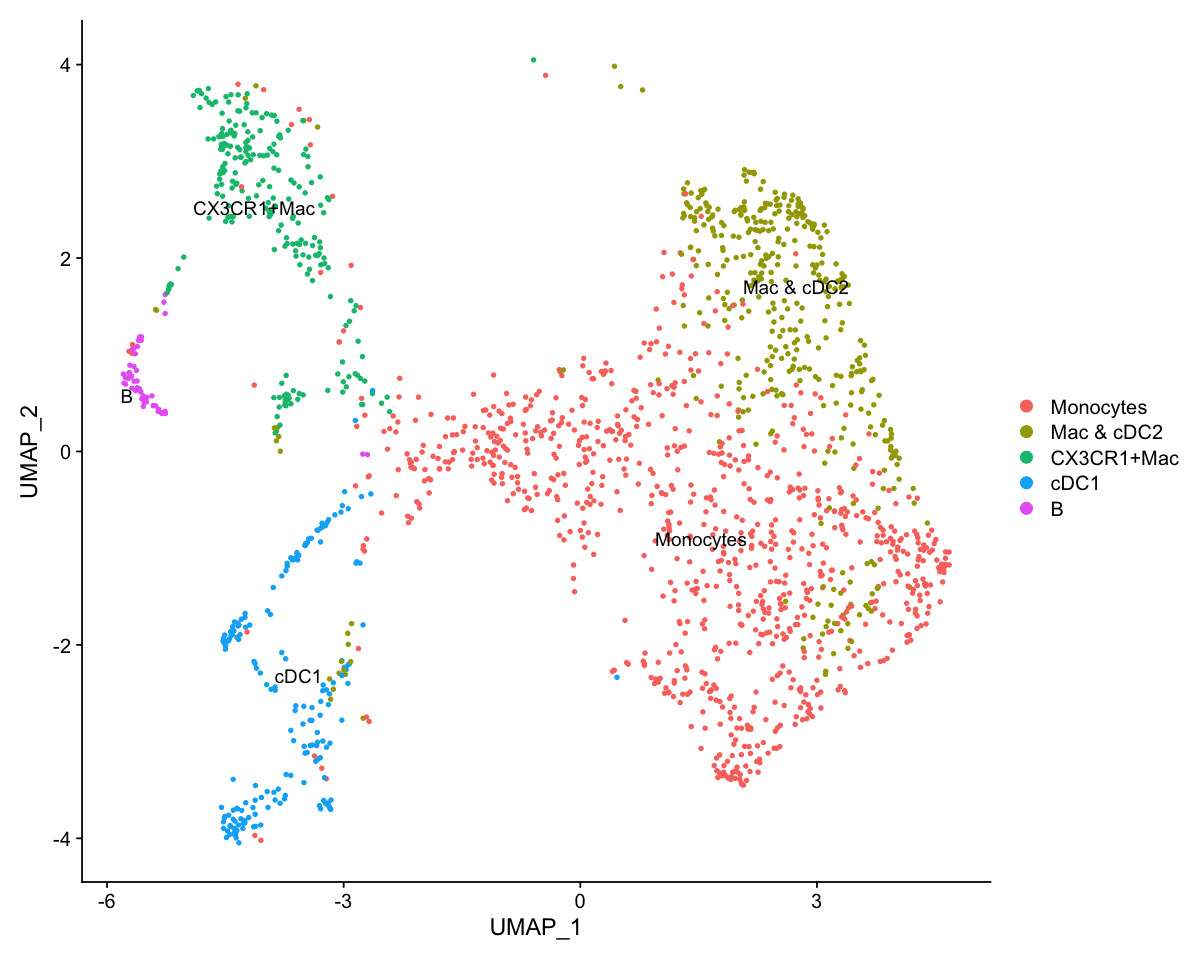

In [10]:
options(repr.plot.width=10, repr.plot.height=8)
DimPlot(myeloid.clean, group.by="celltype0730",label=T, repel=T)

# DEG analyais for cluster 4, 5, 15 (annotation=celltype0627)

In [10]:
Idents(myeloid.clean)<-"celltype0627"
DefaultAssay(myeloid.clean)<-"RNA"
markers.mye<-FindAllMarkers(myeloid.clean, slot = "data", return.thresh = 0.01, only.pos = T)

Calculating cluster 4.Myeloid phagocytes

Calculating cluster 5.Ly2Z+ Myeloid

Calculating cluster 15.CX3CR1+ Mac



In [14]:
# filter the differential expressed genes
markers.mye<-markers.mye[order(markers.mye$cluster, -markers.mye$avg_logFC) , ]

# check the differential expressed genes
markers.mye[markers.mye$cluster=="5.Ly2Z+ Myeloid"&markers.mye$avg_logFC>0.7,]

p_val        avg_logFC pct.1 pct.2 p_val_adj    cluster         gene   
Gm42418 1.135743e-62 1.4411073 0.994 0.997 1.784139e-58 5.Ly2Z+ Myeloid Gm42418
Gm26917 1.519323e-08 1.4083758 0.493 0.480 2.386704e-04 5.Ly2Z+ Myeloid Gm26917
Cbfa2t3 5.435077e-16 0.8327073 0.275 0.140 8.537962e-12 5.Ly2Z+ Myeloid Cbfa2t3
Lars2   1.740310e-07 0.8133212 0.466 0.450 2.733853e-03 5.Ly2Z+ Myeloid Lars2  
Wdfy4   6.653189e-13 0.7205933 0.188 0.082 1.045149e-08 5.Ly2Z+ Myeloid Wdfy4